# Prominent Edge - ticket status

Make sure to install seaborn and pandas modules

```sh
pip install seaborn pandas
```

In [158]:
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib import dates as mdates

sns.set()
sns.set_style('whitegrid')
%matplotlib inline

## Reading data.

In [2]:
df = pd.read_csv('tickets.csv')
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
df['resolved_at'] = pd.to_datetime(df['resolved_at'])
df.sort_values(by='created_at', ascending=False, inplace=True)

df.head()

,Unnamed: 0,id,subject,status_name,assigned_group,created_at,updated_at,first_responded_at,closed_at,resolved_at
0,0,1592,FireCARES - Access.,open,Unassigned,2018-02-23 20:38:38,2018-02-23 20:38:38,NaN,NaN,NaT
1,1,1591,FireCARES - New feedback received.,open,Department and station data updates,2018-02-23 18:03:12,2018-02-23 18:03:12,NaN,NaN,NaT
2,2,1590,FireCARES - Access.,open,Unassigned,2018-02-23 17:02:40,2018-02-23 17:02:40,NaN,NaN,NaT
3,3,1589,Jurisdictional Boundary Question,closed,Department and station data updates,2018-02-23 01:01:13,2018-02-23 01:04:22,NaN,2018-02-23T01:04:21Z,2018-02-23 01:04:21
4,4,1588,Station Data Question,open,Department and station data updates,2018-02-23 00:59:16,2018-02-23 01:17:00,2018-02-23T01:16:56Z,NaN,NaT


## Data processing

### Modified 'resolved' value to 'closed'

In [3]:
df.loc[df['status_name'] == 'closed', 'status_name'] = 'resolved'

### 1. Average first response time

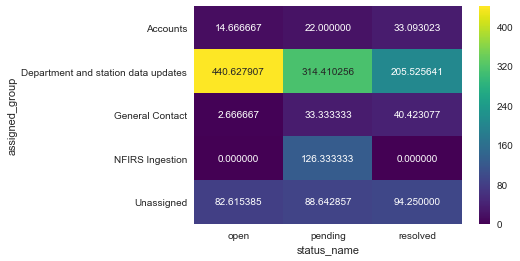

In [4]:
# Removing null values for first_responded_at column.
df_responded = df.loc[(~df['first_responded_at'].isnull())]
df_responded['first_responded_at'] = pd.to_datetime(df_responded['first_responded_at'])

df_responded['delta'] = abs(df_responded['first_responded_at'] - df_responded['created_at']).astype('timedelta64[h]')
df_responded_reduced = df_responded[['assigned_group', 'status_name', 'delta']]

df_groups = df_responded_reduced.groupby(['assigned_group', 'status_name']).mean()
df_heatmap = df_groups.pivot_table(index='assigned_group', columns='status_name', values='delta', fill_value=0)
sns.heatmap(df_heatmap, annot=True, fmt="f", cmap='viridis');

###  2. Average resolution/closed time

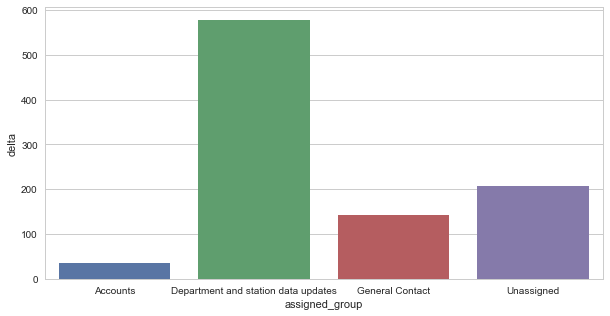

In [5]:
resolved_df = df.loc[(df['status_name'] == 'resolved')]
resolved_df['delta'] = abs(resolved_df['created_at'] - resolved_df['resolved_at']).astype('timedelta64[h]')

reduced_df = resolved_df[['assigned_group', 'delta']]
assigned_means_df = reduced_df.groupby(['assigned_group']).mean().reset_index()

#resolved_df.drop('delta', axis=1, inplace=True)

plt.figure(figsize=(10,5))
sns.barplot(assigned_means_df.assigned_group, assigned_means_df.delta);

### 3. Total count of tickets by status, by group

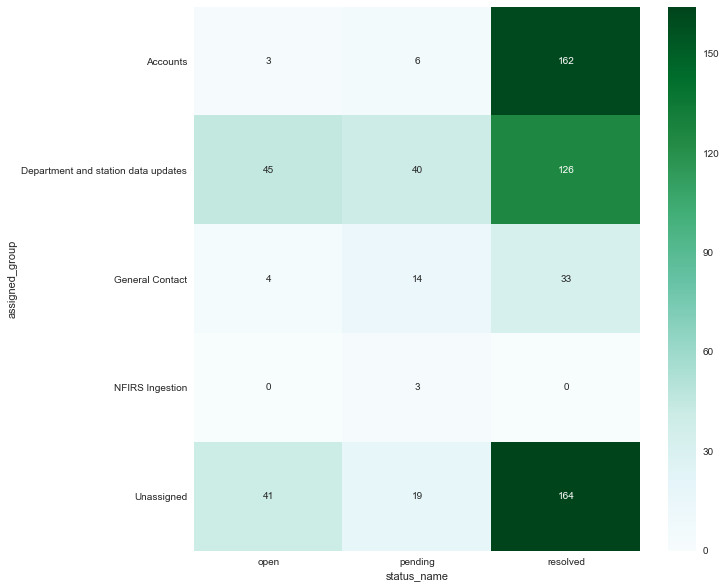

In [6]:
df_groups = df.groupby(['status_name', 'assigned_group']).size().reset_index(name='count')
df_heatmap = df_groups.pivot_table(index='assigned_group', columns='status_name', values='count', fill_value=0)
plt.figure(figsize=(10, 10))
sns.heatmap(df_heatmap, annot=True, fmt="d", cmap='BuGn');

### 4. Weekly/monthly breakdown of new tickets by status by group (only last week/current week, last month/current month)

In [7]:
def create_delta_tickets(df, month=False, range_val=-5):
    time_delta, freq = pd.to_timedelta(7, unit='d'), 'W-MON'
    if month:
        time_delta, freq = pd.to_timedelta(1, unit='M'), 'M'
    
    df['delta'] = df['created_at'] - time_delta
    group_by_list = ['assigned_group', 'status_name', pd.Grouper(key='delta', freq=freq)]
    df_dates_count = df.groupby(group_by_list).size().unstack().fillna(0).stack().reset_index(name='count').sort_values('delta')
    df_dates_count['delta'] = df_dates_count['delta'].dt.date
    
    condition = (df_dates_count['delta'] >= df_dates_count['delta'].unique()[range_val])
    delta_tickets = df_dates_count.loc[condition]
    delta_tickets.sort_values(by=['assigned_group', 'status_name'], inplace=True)
    
    return delta_tickets

#### 4.1 Weekly

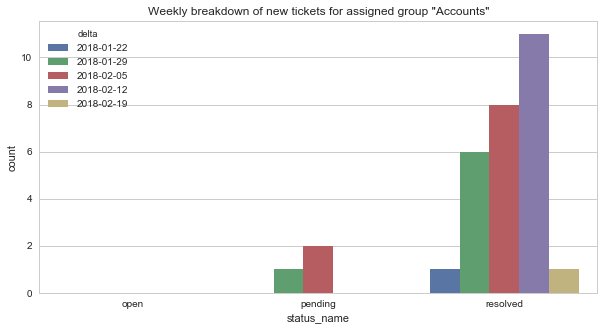

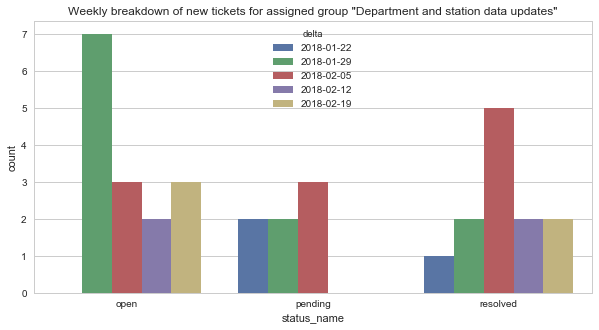

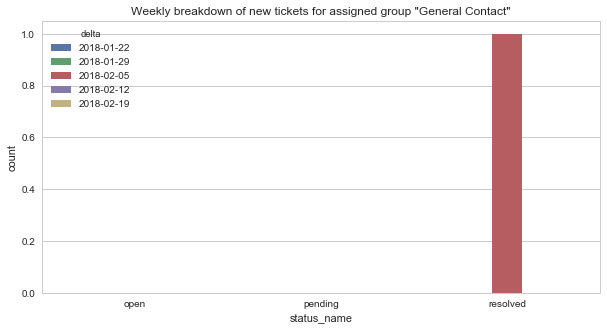

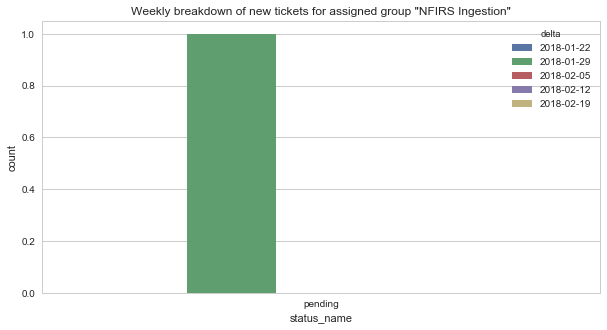

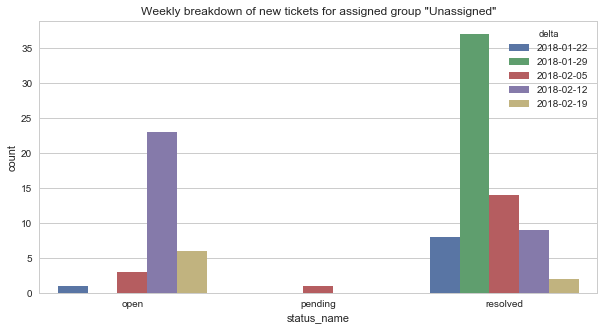

In [8]:
delta_tickets = create_delta_tickets(df)
assigned_groups = delta_tickets['assigned_group'].unique()
for assigned_group in assigned_groups:
    plt.figure(figsize=(10,5))
    assigned_df = delta_tickets.loc[(delta_tickets['assigned_group'] == assigned_group)]

    ax = sns.barplot(x="status_name", y="count", hue="delta", data=assigned_df)
    ax.set_title('Weekly breakdown of new tickets for assigned group "{0}"'.format(assigned_group))

#### 4.2 Monthly

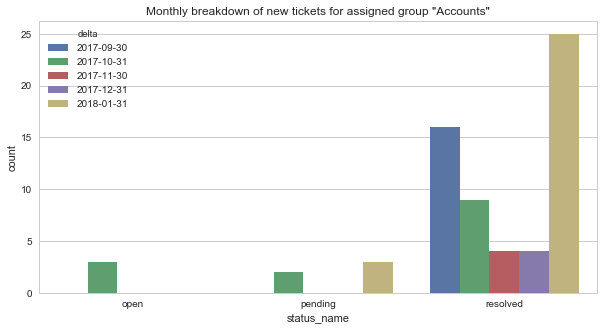

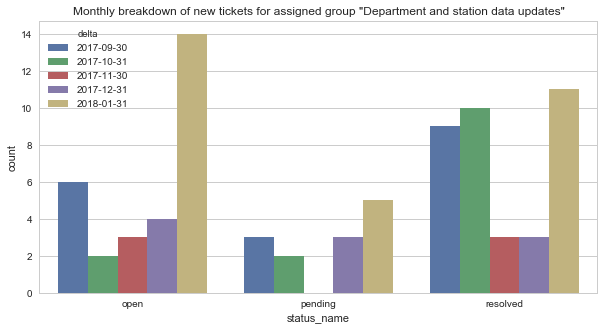

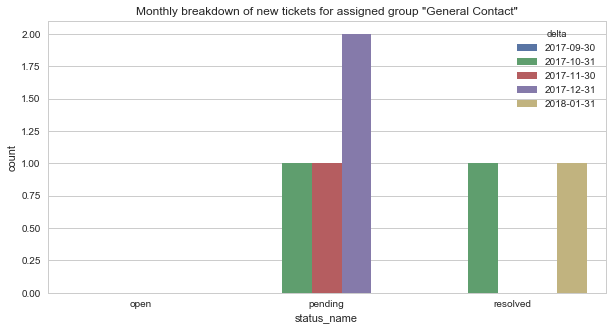

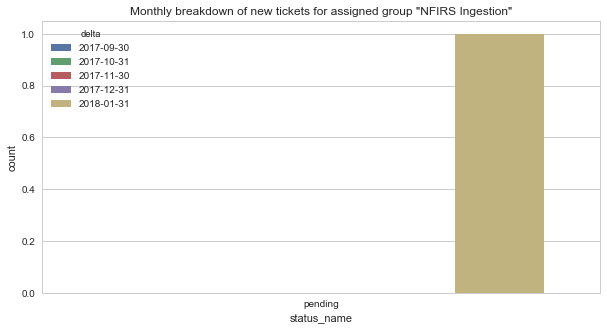

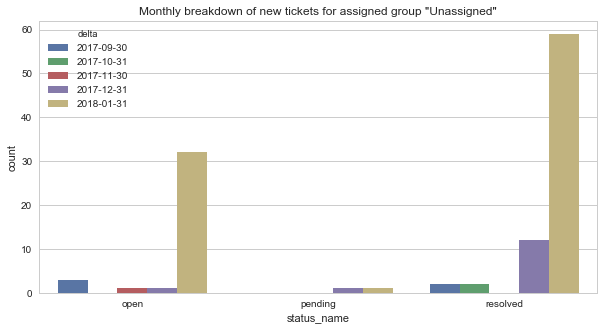

In [9]:
delta_tickets = create_delta_tickets(df, month=True)
assigned_groups = delta_tickets['assigned_group'].unique()
for assigned_group in assigned_groups:
    plt.figure(figsize=(10,5))
    assigned_df = delta_tickets.loc[(delta_tickets['assigned_group'] == assigned_group)]

    ax = sns.barplot(x="status_name", y="count", hue="delta", data=assigned_df)
    ax.set_title('Monthly breakdown of new tickets for assigned group "{0}"'.format(assigned_group))

## 5. Weekly breakdown of new tickets

In [10]:
def create_delta_tickets_time(df, month=False, range_val=-5):
    freq = 'W-MON'
    if month:
        freq = 'M'
    
    df_reduced = df[['assigned_group', 'created_at', 'delta']]
    group_by_list = ['assigned_group', pd.Grouper(key='created_at', freq=freq)]
    df_dates_count = df_reduced.groupby(group_by_list).mean().unstack().fillna(0).stack().reset_index()
    df_dates_count.sort_values(by='created_at', inplace=True)
    df_dates_count['created_at'] = df_dates_count['created_at'].dt.date

    condition = (df_dates_count['created_at'] >= df_dates_count['created_at'].unique()[range_val])
    delta_tickets = df_dates_count.loc[condition]
    delta_tickets.sort_values(by=['assigned_group'], inplace=True)
    
    return delta_tickets

### 5.1 Average First response time by group

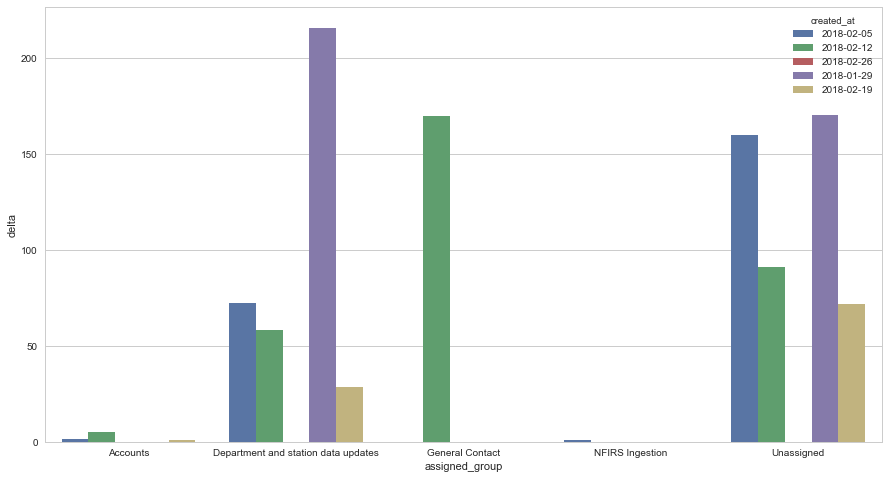

In [11]:
delta_tickets = create_delta_tickets_time(df_responded)
ax = plt.figure(figsize=(15, 8))
ax = sns.barplot(x="assigned_group", y="delta", hue="created_at", data=delta_tickets)

### 5.2 Average Resolution/resolved time by group

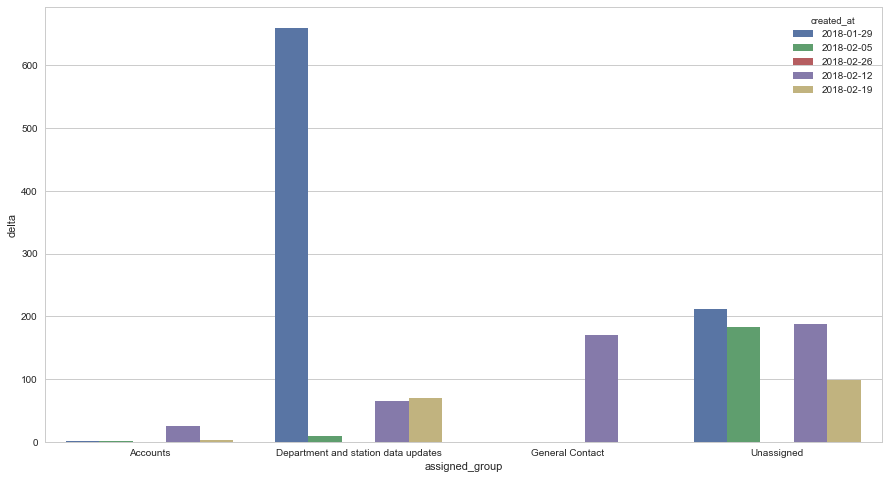

In [12]:
delta_tickets = create_delta_tickets_time(resolved_df)
ax = plt.figure(figsize=(15, 8))
ax = sns.barplot(x="assigned_group", y="delta", hue="created_at", data=delta_tickets)

## 6.  Delta of ticket status count by group compared to...

In [13]:
def estimate_deltas(delta_tickets):
    results = []
    for group in delta_tickets['assigned_group'].unique():
        for status in delta_tickets['status_name'].unique():
            condition = (delta_tickets['assigned_group'] == group) & (delta_tickets['status_name'] == status)
            values = delta_tickets.loc[condition]['count'].tolist()
            if len(values) != 0:
                delta_value = abs(values[0] - values[1])
                results.append({'assigned_group': group, 'status_name': status, 'delta': delta_value})

    return pd.DataFrame(results)[['assigned_group', 'status_name', 'delta']]

### 6.1 prior week

In [14]:
delta_tickets = create_delta_tickets(df, month=False, range_val=-2)
deltas_week = estimate_deltas(delta_tickets)
deltas_week

,assigned_group,status_name,delta
0,Accounts,open,0.0
1,Accounts,pending,0.0
2,Accounts,resolved,10.0
3,Department and station data updates,open,1.0
4,Department and station data updates,pending,0.0
5,Department and station data updates,resolved,0.0
6,General Contact,open,0.0
7,General Contact,pending,0.0
8,General Contact,resolved,0.0
9,NFIRS Ingestion,pending,0.0


### 6.2 prior month

In [15]:
delta_tickets = create_delta_tickets(df, month=True, range_val=-2)
deltas_month = estimate_deltas(delta_tickets)
deltas_month

,assigned_group,status_name,delta
0,Accounts,open,0.0
1,Accounts,pending,3.0
2,Accounts,resolved,21.0
3,Department and station data updates,open,10.0
4,Department and station data updates,pending,2.0
5,Department and station data updates,resolved,8.0
6,General Contact,open,0.0
7,General Contact,pending,2.0
8,General Contact,resolved,1.0
9,NFIRS Ingestion,pending,1.0


## 7. Delta of ticket first response time, resolution/close time by group compared to prior week/month

In [16]:
def estimate_deltas_time(delta_tickets):
    results = []
    for group in delta_tickets['assigned_group'].unique():
        condition = (delta_tickets['assigned_group'] == group)
        values = delta_tickets.loc[condition]['delta'].tolist()
        if len(values) != 0:
            delta_value = abs(values[0] - values[1])
            results.append({'assigned_group': group, 'delta': delta_value})

    return pd.DataFrame(results)[['assigned_group', 'delta']]

### 7.1 Response time - week.

In [17]:
delta_tickets = create_delta_tickets_time(df_responded, month=False, range_val=-2)
deltas_responded_week = estimate_deltas_time(delta_tickets)
deltas_responded_week

,assigned_group,delta
0,Accounts,1.000000
1,Department and station data updates,28.333333
2,General Contact,0.000000
3,NFIRS Ingestion,0.000000
4,Unassigned,71.875000


### 7.2 Response time - month.

In [18]:
delta_tickets = create_delta_tickets_time(df_responded, month=True, range_val=-2)
deltas_responded_month = estimate_deltas_time(delta_tickets)
deltas_responded_month

,assigned_group,delta
0,Accounts,2.857143
1,Department and station data updates,114.596491
2,General Contact,137.500000
3,NFIRS Ingestion,1.000000
4,Unassigned,30.436782


### 7.3 Resolution/close time - week

In [19]:
delta_tickets = create_delta_tickets_time(resolved_df, month=False, range_val=-2)
deltas_resolution_week = estimate_deltas_time(delta_tickets)
deltas_resolution_week

,assigned_group,delta
0,Accounts,3.363636
1,Department and station data updates,70.000000
2,General Contact,0.000000
3,Unassigned,97.888889


### 7.4 Resolution/close time - month

In [20]:
delta_tickets = create_delta_tickets_time(resolved_df, month=True, range_val=-2)
deltas_resolution_month = estimate_deltas_time(delta_tickets)
deltas_resolution_month

,assigned_group,delta
0,Accounts,28.410000
1,Department and station data updates,197.000000
2,General Contact,170.000000
3,Unassigned,51.014589


## 8. New tickets by date and group

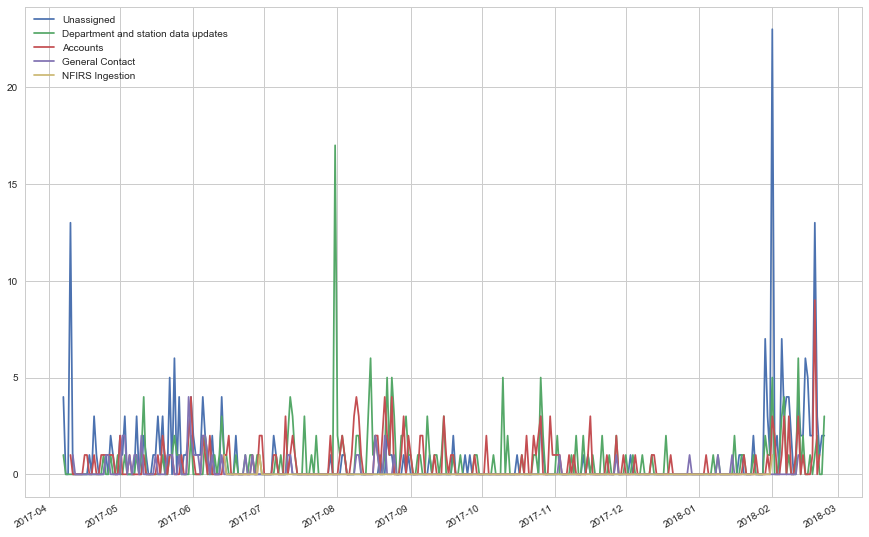

In [159]:
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator() # every day
yearsFmt = mdates.DateFormatter('%Y-%m')

df_date = df.copy()
groups = df_date['assigned_group'].unique()

fig, ax = plt.subplots(figsize=(15, 10))
# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(days)

for group in groups:
    df_assigned = df_date.loc[(df_date['assigned_group'] == group)]
    df_group_date = df_assigned.set_index('created_at').groupby([pd.TimeGrouper('D')])\
                           .size().reset_index(name='count')
    df_group_date['created_at'] = df_group_date['created_at'].dt.date
    data = df_group_date.as_matrix()
    ax.plot(data[:, 0], data[:, 1])

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

fig.autofmt_xdate()
ax.legend(groups)    